# Comparing the Gospel Accounts with Natural Language Processing 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import nltk
from nltk import word_tokenize, pos_tag
import gensim
from gensim import matutils, models
import scipy.sparse
from scipy.linalg import svd


bible=pd.read_csv("webtext.txt",dtype={"id": np.int64, "b": np.int64,"c": np.int64,"v": np.int64,"t": str},index_col="id")

## Introduction

The Bible contains four accounts of Jesus' life. These four gospels (ascribed to Mark, Matthew, Luke, and John) tell the story in four different ways, with different audiences and for different purposes. While the main gist of the accounts is the same, there are also significant differences, and at times contradictions, between them. These discrepancies and the relationships between the four gospel accounts have been studied and debated by generations of scholars. These issues are a patent playing field on which to try out Natural Language Processing techniques. 

## Sources and Acknowledgments

For this NLP analysis, I use the corpus of the World English Bible (web) as available here:

https://github.com/scrollmapper/bible_databases/blob/master/csv/t_web.csv

I gratefully acknowledge Alice Zhao's fantastic NLP tutorial, which is available here:

https://www.youtube.com/watch?v=xvqsFTUsOmc

## Preliminaries

### Preparing the Data

Let's take a first look at the dataset: The Bible is divided into books, chapters, and verses. Each row of the dataset corresponds to a verse. The actual text of the verse is stored in the text column as a string. The book, chapter, and verse numbers associated with that text are given in three distinct numerical columns. The index column contains a number that summarizes book, chapter, and verse information.

To get a visual impression, let's print the first five rows to the screen.

Not surprisingly, the very first row opens with the original *Hello World!* message:

"*In the beginning, God created the heavens and the earth...*" 

In [2]:
bible.head()

,b,c,v,t
id,,,,
1001001,1,1,1,"In the beginning God{After ""God,"" the Hebrew h..."
1001002,1,1,2,Now the earth was formless and empty. Darkness...
1001003,1,1,3,"God said, ""Let there be light,"" and there was ..."
1001004,1,1,4,"God saw the light, and saw that it was good. G..."
1001005,1,1,5,"God called the light Day, and the darkness he ..."


Rather than the entire Bible, I want to focus on the four gospel accounts, which are the 40th through 43th books of the Bible. So the next step is to create four dataframes, one for each gospel. 

In [3]:
gospels=["Mark","Matthew","Luke","John"]
matthew=bible[bible["b"]==40]
mark=bible[bible["b"]==41]
luke=bible[bible["b"]==42]
john=bible[bible["b"]==43]

To check that this works, let's take a look at the dataframe containing Mark's gospel:

In [4]:
mark.head()

,b,c,v,t
id,,,,
41001001,41,1,1,"The beginning of the Gospel of Jesus Christ, t..."
41001002,41,1,2,"As it is written in the prophets, ""Behold, I s..."
41001003,41,1,3,"The voice of one crying in the wilderness, 'Ma..."
41001004,41,1,4,John came baptizing{To baptize means to immers...
41001005,41,1,5,All the country of Judea and all those of Jeru...


## Preprocessing

Now that we have the corpus we need, let's proceed to some data cleaning. I will subsume the various cleaning steps in a function. These steps include: Removing punctuation, putting everything in lower case, and removing editorial comments which appear in curly brackets in the original corpus. 

In [5]:
def cleaning_step_one(text):
    text=text.replace(","," ").replace('"',"").replace("."," ").replace(";"," ").lower()
    text=text.replace(":"," ").replace("?"," ").replace("!"," ")
    text=text.replace("  "," ")
    text=text.replace("'","")
    text=re.sub("\{.*?\}","",text)
    return text

Now apply the above data cleaning function to each verse of each gospel:

In [6]:
mark=pd.DataFrame(mark.t.apply(lambda x: cleaning_step_one(x)))
matthew=pd.DataFrame(matthew.t.apply(lambda x: cleaning_step_one(x)))
luke=pd.DataFrame(luke.t.apply(lambda x: cleaning_step_one(x)))
john=pd.DataFrame(john.t.apply(lambda x: cleaning_step_one(x)))

Now merge chapters and verses in such a way that each of the four gospels is contained in one long string. Then store the four strings in a dataframe.

In [7]:
mark_string=""
for row in mark.t:
    mark_string+=row

matthew_string=""
for row in matthew.t:
    matthew_string+=row
    
luke_string=""
for row in luke.t:
    luke_string+=row

john_string=""
for row in john.t:
    john_string+=row

dictionary={"Mark": mark_string, "Matthew": matthew_string, "Luke": luke_string, "John": john_string}
df=pd.DataFrame.from_dict(dictionary, orient="index", columns=["Gospel"])
df

,Gospel
Mark,the beginning of the gospel of jesus christ th...
Matthew,the book of the generation of jesus christ the...
Luke,since many have undertaken to set in order a n...
John,in the beginning was the word and the word was...


### Stopwords 

Now let's define the stopwords that should be ignored during analysis. I use the standard set of English stop words that comes with Sci-Kit-Learn. In addition, I have a list of custom stop words. Of course, there is some subjectivity in the choice of that list. There are certrain phrases which are repeated over and over in all the gospel accounts: These words obviously include "son," "father," and "god" as well as the phrase "and then it came to pass." Often, dialogues involve future tense with the word "shall," and so on. Changing the below list of custom stop words and then rerunning the notebook, one can experiment with various possible choices.

In [8]:
custom_stop_words=["said","saying","say","come","came","pass","jesus","father","son","god", "answered",
                   "man","men","lord","things","disciples","day","tell","dont","went","didnt","behold","shall",
                  "house","kingdom","world","away"]

my_stop_words=text.ENGLISH_STOP_WORDS.union(custom_stop_words)

## First Analysis of Gospel Accounts 

### Generating Wordclouds

To get a first idea of the use of language in the four gospels, it is convenient to display a wordcloud for each gospel, thus:

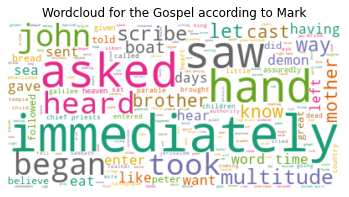

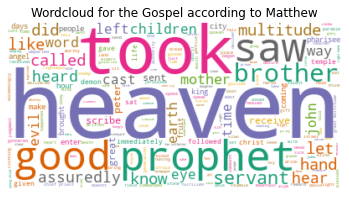

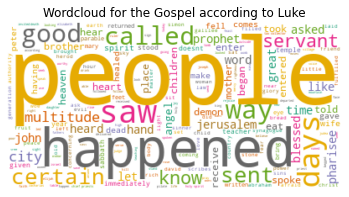

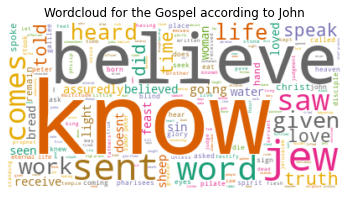

In [9]:
wordcloud=WordCloud(stopwords=my_stop_words, background_color="white", colormap="Dark2", max_font_size=120, random_state=0)

def generate_cloud(gospel):

    wordcloud.generate(df.Gospel[gospel])
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.title("Wordcloud for the Gospel according to {}".format(gospel))
    plt.show()


for gospel in gospels:
    generate_cloud(gospel)

Some first observations are as follows: Mark's use of vocabulary seems more varied than the others. Moreover, we can see that Mark's gospel talks a lot about John (this is John the disciple, however, who need not be the same person as the author of John's gospel!) "Heaven" is very important in Matthew's gospel, but not in Luke's who puts more emphasis on talking about the "people." 

It is well-known that John's gospel focuses more on theological interpretation of events while the other three gospels concentrate on the events of Jesus' life. This could explain why John talks a lot about "knowing" and "believing" things rather than about what actually "happened," as Luke does.

### Producing a Document-Term Matrix

The word clouds provide a first impression of the frequency with which words appear in each gospel. To get a more precise account of the use of language in each gospel, let's generate a document-term matrix. (Sometimes, we rather need its transpose: the term-document-matrix.) It shows for each word and each gospel how often this word appears in that gospel. In order to generate the desired matrix, we use Sci-Kit-Learn's CountVectorizer, thus:

In [10]:
vect=CountVectorizer(stop_words=my_stop_words)
data=vect.fit_transform(df.Gospel)
dff=pd.DataFrame(data.toarray(),columns=vect.get_feature_names())
dff.index=df.index
tdm=dff.transpose()
tdm

,Mark,Matthew,Luke,John
aaron,0,0,1,0
abba,1,0,0,0
abel,0,1,1,0
abiathar,1,0,0,0
abijah,0,2,1,0
...,...,...,...,...
zebedee,4,6,1,1
zebulun,0,2,0,0
zerah,0,1,0,0
zerubbabel,0,2,1,0


### Similarity

Our next goal is to say something about how similar the gospel accounts are to each other in terms of vocabulary. One well-established way to compare document similarity is **cosine similarity.**

(Some explanation of cosine similarity can be found here https://studymachinelearning.com/cosine-similarity-text-similarity-metric/ or here https://en.wikipedia.org/wiki/Cosine_similarity.)

Roughly speaking, when a word shows up n times in one document and m times in the other, this increases cosine similarity by an amount proportional to n times m. Cosine similarity is between zero and one because it is normalized by a measure of how rich the vocabularies of the individual documents are. Computation of cosine similarity is available in Sci-Kit-Learn, and outputs a matrix of the cosine similarities between pairs of columns of the document-term matrix.

In [11]:
cosine_similar_matrix=cosine_similarity(dff,dff)
csm=pd.DataFrame(cosine_similar_matrix, columns=gospels, index=gospels)
csm

,Mark,Matthew,Luke,John
Mark,1.000000,0.807831,0.793922,0.613307
Matthew,0.807831,1.000000,0.823443,0.616687
Luke,0.793922,0.823443,1.000000,0.627418
John,0.613307,0.616687,0.627418,1.000000


By definition, the cosine similarity of each gospel to itself is one, and due to the metric's symmetry, all information is contained in the cosine similarity matrix twice: once above the diagonal and once more below the diagonal. Hence, it is convenient to mask the upper triangle and visualize the lower triangle in a heatmap:

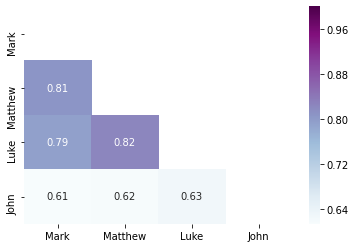

In [12]:
mask = np.triu(np.ones_like(csm, dtype=np.bool))
sns.heatmap(csm, annot=True, xticklabels=gospels, yticklabels=gospels,mask=mask, cmap="BuPu")
plt.rcParams['figure.figsize'] = [16, 16]
plt.show()

In order to interpret this heatmap, the following background information is helpful: Scholars believe that both Matthew and Luke were written on the basis of two sources: Mark and a second source which no longer exists.

(For a quick introduction on the topic, see here: https://en.wikipedia.org/wiki/Two-source_hypothesis and here: https://en.wikipedia.org/wiki/Synoptic_Gospels)

Mark, Matthew, and Luke are known as "synoptic gospels" as they all focus on an account of Jesus' life. John, on the other hand, is more focused on making a number of theological points and is therefore quite different from the other three texts.

The heatmap reflects these relationships between the gospels: First, John is much less similar to the three synoptic gospels than the latter are to each other. Second, Matthew and Luke are most similar, which is in line with the proposition that both drew on the same two sources. Third, they are also very similar to Mark (but less so than they are similar to each other), which is consistent with the idea that Mark was one of these two sources.

It is remarkable that these patterns of similarity can be observed here although (i) the similarity metric only uses a bag of words rather than comparing the actual narratives contained in the gospels, and (ii) the words themselves come from a modern English translation.

### Additional comparisons

In addition, we can also analyze the vocabulary of all gospel accounts combined or directly compare the vocabulary of two gospels, for instance Mark and John.

In [13]:
tdm["All_gospels"]=tdm[gospels].sum(axis=1)
tdm["XS in Mk vs Jh"]=tdm["Mark"]-tdm["John"]

The following line of code defines a subsetting operation that can be used to exclude words that show up only on rare occasions in the four gospels, and see how the ensuing analysis changes as a result. 

In [14]:
tdmm=tdm[tdm["All_gospels"]>0]

Let's see first what are the most common words in the gospel accounts. Again, there is some subjectivity as to whether some of these words should be considered stopwords and excluded from the analysis. One can experiment with various choices by changing the list of custom stop words and then rerunning the notebook. So here is a ranking of the Top 10 words used in all gospels combined, stopwords excluded:

In [15]:
tdmm.sort_values(by="All_gospels",ascending=False).head(10)

,Mark,Matthew,Luke,John,All_gospels,XS in Mk vs Jh
know,19,27,30,96,172,-77
saw,33,39,43,35,150,-2
sent,17,24,34,57,132,-40
heaven,12,68,21,18,119,-6
heard,26,31,30,30,117,-4
took,26,47,24,17,114,9
called,13,33,37,23,106,-10
great,23,36,34,7,100,16
way,21,29,36,13,99,8
asked,36,14,29,20,99,16


Now let's use the additional column to compare Mark's and John's use of vocabulary. To do so, generate a table with those words that are the most over-represented in Mark as compared to John and those which are most over-represented in John as compared to Mark. 

In [16]:
tdmm.sort_values(by="XS in Mk vs Jh",ascending=False)

,Mark,Matthew,Luke,John,All_gospels,XS in Mk vs Jh
immediately,41,19,18,7,85,34
began,27,10,21,3,61,24
scribes,21,22,15,1,59,20
asked,36,14,29,20,99,16
great,23,36,34,7,100,16
...,...,...,...,...,...,...
life,10,18,15,47,90,-37
sent,17,24,34,57,132,-40
believe,12,8,9,58,87,-46
jews,6,5,5,69,85,-63


(One could argue that at least the words in the table above should never be considered stopwords as they are used very differently across different gospels.)

We have already seen before that John loves to "know" things, but aside from that, we can make (at least) two more observations from the table:

First, John hardly mentions the "scribes" which regularly show up in the other three gospels which suggests that John is less interested in Jesus' disputes with the religous authorities than the synoptic gospels are. Second, John uses the word "jews" much more than the other evangelists do. This likely is related to the fact that John was written in a context where the unfolding separation of the Jewish and Christian traditions was a major issue, while the synoptic gospels are believed to predate John. (Obviously, the earliest followers of Jesus still saw themselves as Jewish, so up to a certain point in time, it would not have been natural to extensively talk about Jews in third person.)

## Topic Modeling 

Now I proceed to a clustering or topic modeling exercise. The point is to find clusters of words that typically show up together in a gospel, and could therefore have a meaningful relation with each other. Some information on topic modeling can be found here https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In this notebook, I will restrict attention to nouns only, but this is by no means the only way one could proceed.

The first step is to make a new version of the existing dataframe which omits all words other than nouns. Python's nltk package comes with a dictionary that categorizes English words by whether they are nouns, adjectives, and so on. 

In [17]:
def select_nouns(text):
    noun=lambda pos: pos[:2]=="NN" 
    tokenized=word_tokenize(text)
    words=[word for (word,pos) in pos_tag(tokenized) if noun(pos)]
    return " ".join(words) 

only_nn=pd.DataFrame(df.Gospel.apply(select_nouns))
only_nn

,Gospel
Mark,beginning gospel jesus son god prophets messen...
Matthew,book generation jesus son david son abraham fa...
Luke,order matters beginning eyewitnesses ministers...
John,beginning word word god word beginning things ...


Now create a term-document matrix with nouns only, and cast it as a numpy array.

In [18]:
vect=CountVectorizer(stop_words=my_stop_words)
data_nn=vect.fit_transform(only_nn.Gospel)
df_nn=pd.DataFrame(data_nn.toarray(),columns=vect.get_feature_names())
df_nn.index=only_nn.index
dff_nn=df_nn.transpose()
arr=dff_nn.to_numpy()
arr.shape

(1836, 4)

This numpy array corresponds to a matrix with as many rows as there are nouns in the vocabulary and four columns, one for each gospel.

In order to identify clusters, I apply **Singular Value Decomposition** to this matrix. This means finding matrices U, S, and VT (transpose of V) such that the product U x S x VT equals the original term-document matrix. It is a known fact that the desired matrices exist and are unique (up to changing all the signs). We can use SciPy to compute the Singular Value Decomposition, thus:  

In [19]:
U,S,VT=svd(arr,full_matrices=False)
U.shape, S.shape, VT.shape

((1836, 4), (4,), (4, 4))

The interpretation is as follows: Each row of the U-matrix corresponds to a word, and each column to some cluster of words (potentially, a topic). The entry in row i and column j of the U-matrix tells us how much word i is associated with the word cluster j. In the VT-matrix, each row corresponds to a cluster and each column to a gospel. The entry in row i and column j of the VT-matrix tells us how prominent cluster i is in gospel j. The S-matrix is a diagonal matrix: All it does is to scale the prominence of different clusters. Let's have a look at the strength of clusters:

In [20]:
print(S)

[271.39499895 110.96747043  78.34781451  59.26714951]


We see that one cluster is much stronger than the others. Let's focus on just the first two clusters, and use a heatmap to visualize the prominence of these clusters in the different gospels:

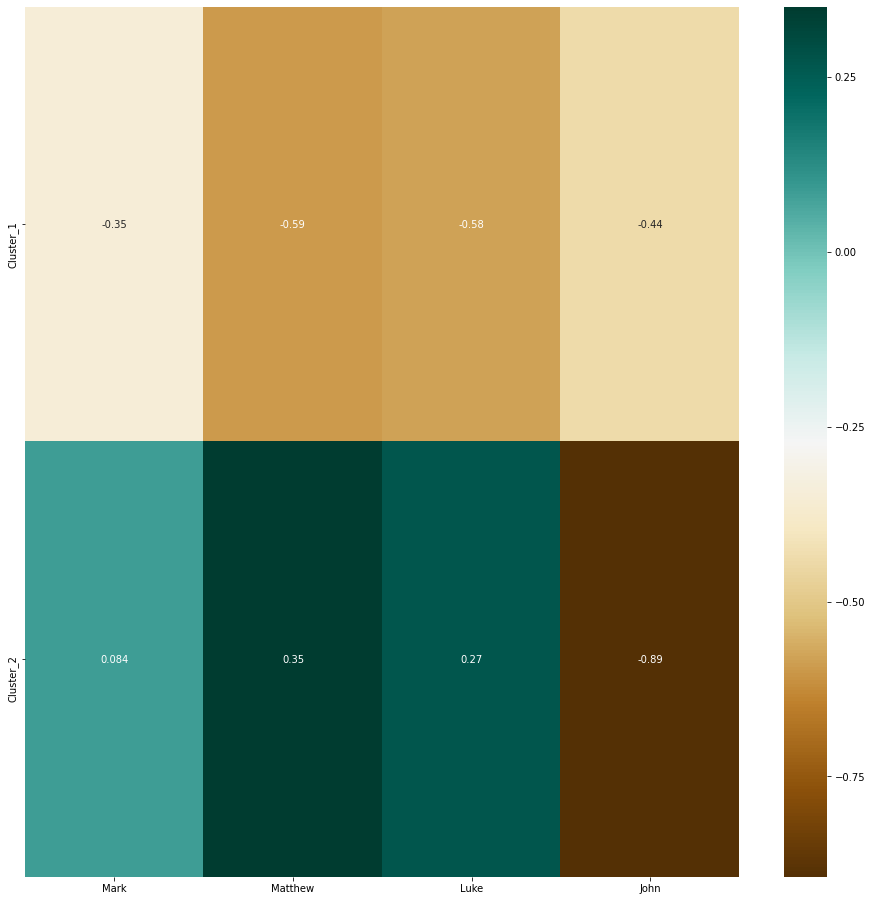

In [21]:
clusters=["Cluster_1","Cluster_2","Cluster_3","Cluster_4"]
word_cluster_matrix=pd.DataFrame(data=U, columns=clusters, index=dff_nn.index)

cluster_document_matrix=pd.DataFrame(data=VT[:2], columns=gospels, index=word_cluster_matrix.columns[:2])

sns.heatmap(cluster_document_matrix, annot=True, xticklabels=gospels, yticklabels=clusters[:2],
            cmap="BrBG")
plt.rcParams['figure.figsize'] = [8, 8]
plt.show()

We see that the first cluster is present primarily in Matthew and Luke, with almost equal prominence, and is less important in John and Mark. Indeed, there are some narratives which are present only in Matthew and Luke (known as the "double tradition"). So one speculative interpretation could be that the words in the first cluster are related to a topic that is discussed within the double tradition material. Let's have a look at the most important words in Cluster 1:

In [22]:
print(word_cluster_matrix.Cluster_1.describe())
word_cluster_matrix.Cluster_1.sort_values().head(10)

count    1836.000000
mean       -0.010795
std         0.020697
min        -0.188018
25%        -0.009402
50%        -0.004262
75%        -0.002131
max        -0.001278
Name: Cluster_1, dtype: float64


way         -0.188018
heaven      -0.176213
people      -0.172805
days        -0.165667
hand        -0.164942
pharisees   -0.160201
life        -0.160161
multitude   -0.159045
spirit      -0.156359
word        -0.152510
Name: Cluster_1, dtype: float64

Ideally, we would immediately recognize some obvious overarching topic behind this collection of words. In reality, it is not that straightforward, but at least some things can be seen here: Indeed, the double tradition contains disputes with the pharisees, and the word "pharisees" belongs to Cluster 1. The disputes in which Jesus engages have to do with the right "way" to proceed, Jesus uses metaphors to say something about what "heaven" looks like, and he wishes to redeem the "people." 

The second strongest cluster is closely associated with John's gospel. Let's see which words make up the cluster:

In [23]:
word_cluster_matrix.Cluster_2.sort_values().head()

jews    -0.507036
life    -0.277766
truth   -0.186904
water   -0.175306
word    -0.140180
Name: Cluster_2, dtype: float64

Compared to Cluster 1, it is a bit easier to identify what the overarching topic could be: We have already mentioned the separation of Jewish and Christian traditions that are prominent in John's gospel. Also, we have seen before how John cares about theological interpretations of event, and how much he used verbs like "know" or "believe." In the topic modeling, this is reflected in his use of the term "truth." Also, "truth," "water," and "life" have to do with the baptism, which involves water, supposedly gives new life that is marked by truth.   

## Some further ideas 

-- Possibilities for topic modeling are a bit restricted as there are only four documents (gospels). Instead, one could use the dataframe with the chapters of Mark for topic modeling across the sixteen chapters.
 
-- Including words other than nouns in topic modeling (could be interesting because some verbs like "know" "believe" and "happen" are very prominent and differ across the four documents

-- Do more preprocessing, in particular stemming to improve the analysis of vocabulary.